Forecasting BTC-USD price using ARIMA (basically backtesting) <br>
I am really sorry if this jupyter notebook is not tidy, I did my best

## Importing Data

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import AutoReg
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.2 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=293379 sha256=f29f848ab55dad15c0b6f04c0651db43bde62ab7a5887791fc8bde8445b742a3
  Stored in directory: /root/.cache/pip/wheels/06/80/9b/98db0d58349a2f5c09f8406789ade4270762f97b7d26f2fa22
Successfully built peewee
Note: you may need to restart the kernel to use updated packages.


In [5]:
import yfinance as yf
ticker_symbol = 'BTC-USD'
data = yf.download(ticker_symbol, start='2023-06-28', end='2024-06-28')
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                    Open          High           Low         Close  \
Date                                                                 
2023-06-28  30696.560547  30703.279297  29921.822266  30086.246094   
2023-06-29  30086.187500  30796.250000  30057.203125  30445.351562   
2023-06-30  30441.353516  31256.863281  29600.275391  30477.251953   
2023-07-01  30471.847656  30641.289062  30328.865234  30590.078125   
2023-07-02  30587.269531  30766.140625  30264.019531  30620.769531   

               Adj Close       Volume  
Date                                   
2023-06-28  30086.246094  14571500779  
2023-06-29  30445.351562  13180860821  
2023-06-30  30477.251953  26387306197  
2023-07-01  30590.078125   9086606733  
2023-07-02  30620.769531  10533418042  


In [6]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-06-28,30696.560547,30703.279297,29921.822266,30086.246094,30086.246094,14571500779
2023-06-29,30086.187500,30796.250000,30057.203125,30445.351562,30445.351562,13180860821
2023-06-30,30441.353516,31256.863281,29600.275391,30477.251953,30477.251953,26387306197
2023-07-01,30471.847656,30641.289062,30328.865234,30590.078125,30590.078125,9086606733
2023-07-02,30587.269531,30766.140625,30264.019531,30620.769531,30620.769531,10533418042


Use close price because it is commonly used

In [7]:
df = data[['Close']]

In [8]:
df.head()

,Close
Date,
2023-06-28,30086.246094
2023-06-29,30445.351562
2023-06-30,30477.251953
2023-07-01,30590.078125
2023-07-02,30620.769531


In [9]:
df.shape

(366, 1)

## Exploration before Differencing

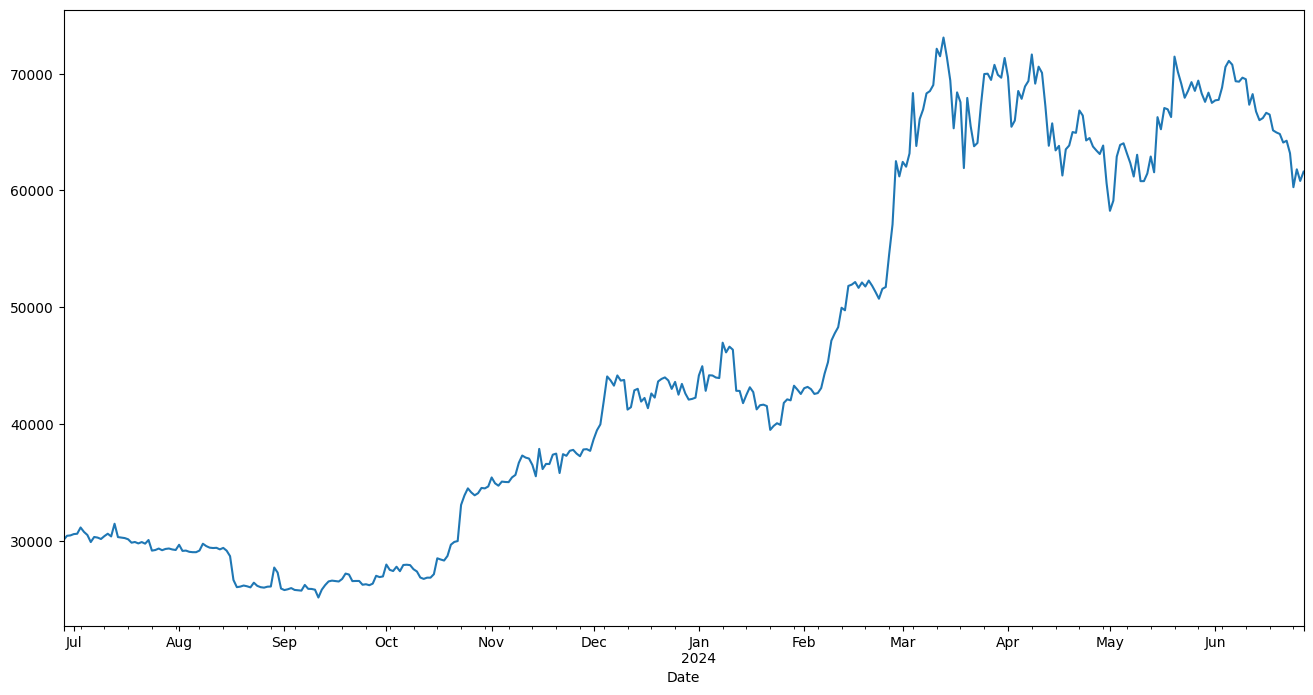

In [10]:
plt.figure(figsize = (16,8))
df['Close'].plot();

From this we can see the uprising trend of the price. <br>
I don't seem to see the seasonality from this data

## ADF TEST (Stationarity)

In [11]:
def adf_test(timeseries):
    print('Result of Augmented Dickey-fuller Test')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [12]:
adf_test(df['Close'])

Result of Augmented Dickey-fuller Test
Test Statistic                  -0.931287
p-value                          0.777495
#Lags Used                      14.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


## Augmented Dickey Fuller Test
Extension of the normal Dickey-Fullter test for more complex model than AR(1). ADF used for larger sized set of time series models which can be more complicated.
<br>
This test under the following assumption: <br>
1. **Null Hypothesis $(H_{0})$:** There exists a unit root in the time series and it is non-stationary. **Unit root = 1** or **$\delta=0$**.
2. **Alternate Hypothesis $(H_{1})$:** There exist no unit root in the time series and it is stationary. **Unit root < 1** or **$\delta<0$**.

### Explanation
Based on the Test Statistic, the value is much higher than critical value (5%) meaning cannot reject the null hypothesis proving the time series is non-stationary <br>
The p-value also greater than common significance like 0.05 meaning not enough evidence to reject the null hypothesis meaning the time series is non-stationary <br>


## Differencing
One famous way to turn non-stationary into stationaryis differencing, differencing is usually done in only 0,1, and at most 2 order. <br>
Lets try 1st differencing

In [13]:
df_diff = df.diff()
df_diff = df_diff.dropna()

In [14]:
df_diff.head()

,Close
Date,
2023-06-29,359.105469
2023-06-30,31.900391
2023-07-01,112.826172
2023-07-02,30.691406
2023-07-03,535.669922


In [15]:
adf_test(df_diff['Close'])

Result of Augmented Dickey-fuller Test
Test Statistic                  -3.878210
p-value                          0.002201
#Lags Used                      13.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


The Test Statistic is lower than any of the critical value meaning having evidence against the null hypotesis and accepting the alternate hypothesis, indicating stationary time series, <br>
The p value is lower than most common significance level 0.05, indicating stationary time series.

## PACF and ACF PLOT
To determine the (p and q) parameter of AR(p), MA(q), ARMA(p,q), ARIMA(p,d,q), and SARIMA(p,d,q)(P,D,Q,s). We need to use PACF for the p and ACF for the q, the d is for differencing because ARIMA including differencing in the model. <br>
We also going to explore auto.arima functing from pmdarima.

We will look into raw data and differenced data when plotted in ACF and PACF

## RAW Data

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)')

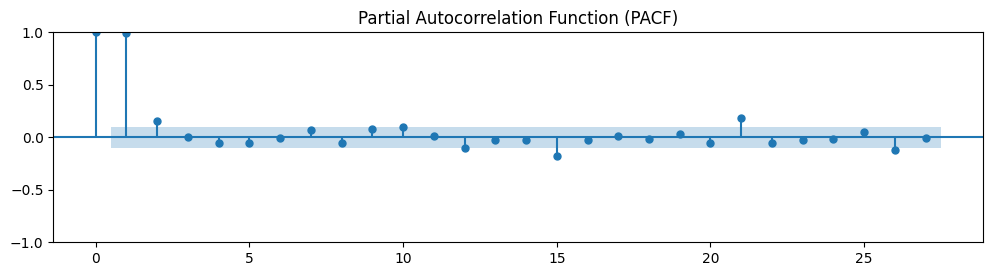

In [33]:
#PACF df_diff
plt.figure(figsize=(12, 6))
plt.subplot(212)
plot_pacf(df['Close'], ax=plt.gca(), lags=27, method='ols')
plt.title('Partial Autocorrelation Function (PACF)')

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

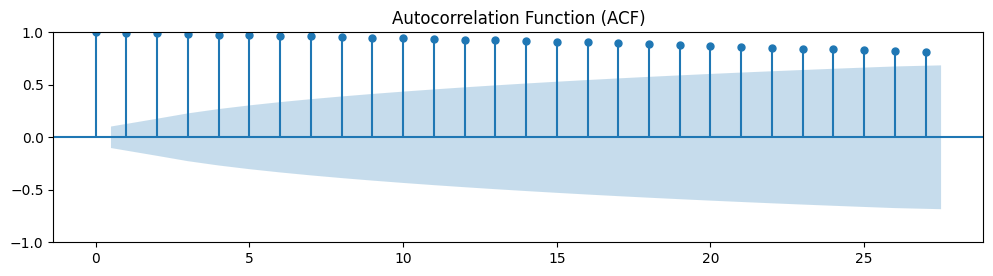

In [34]:
#ACF df_diff
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['Close'], ax=plt.gca(), lags=27)
plt.title('Autocorrelation Function (ACF)')

This ACF also showing the raw data are not stationary by: <br>
1. Every Lag outside the confidence interval.
2. The lags are decreasing gradually.
3. The confidence area is getting wider.

### DIfferenced Data

Text(0.5, 1.0, 'Partial Autocorrelation Function (PACF)')

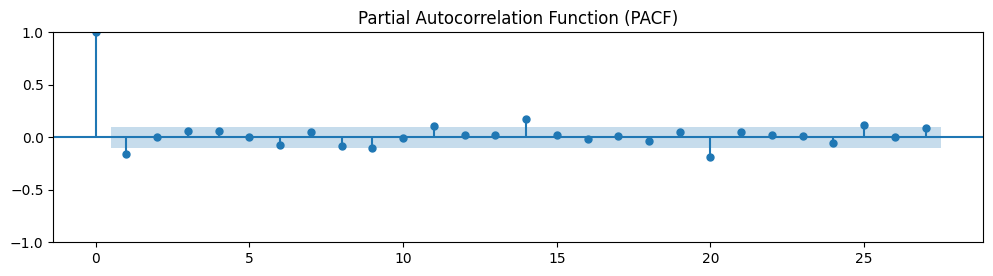

In [32]:
#PACF df_diff
plt.figure(figsize=(12, 6))
plt.subplot(212)
plot_pacf(df_diff['Close'], ax=plt.gca(), lags=27, method='ols')
plt.title('Partial Autocorrelation Function (PACF)')

The only significant lag i see is in 20.

Text(0.5, 1.0, 'Autocorrelation Function (ACF)')

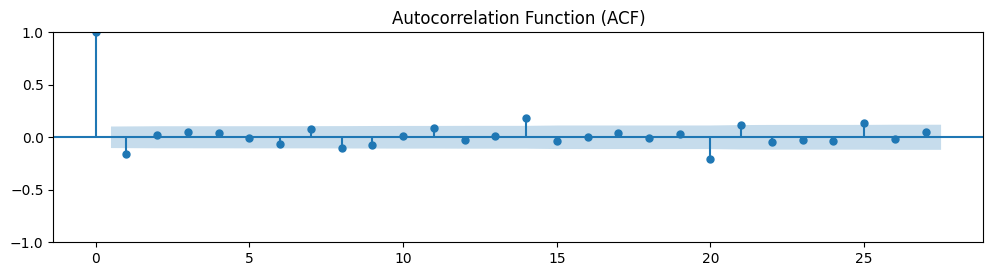

In [31]:
#ACF df_diff
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df_diff['Close'], ax=plt.gca(), lags=27)
plt.title('Autocorrelation Function (ACF)')

The only significant lag i see is in 20.

As i read, when the ACF and PACF plot looked similar it might caused by if the data is not stationary, so i pulled up this check_stationary test hell yeah. <br>
Hmm it appear the data is stationary, the other suspicion is the data is seasonal and i can't capture it by looking at it ("hehe silly me right?"). <br>
Another suspicion is i am under differencing the data (WTF) right?, stats so hard man so many to consider and not all is factual (literally venting my ass off) <br>

In [35]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [36]:
check_stationarity(df_diff['Close'])

ADF Statistic: -3.878210
p-value: 0.002201
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Stationary


Similar pattern in both ACF and PACF often indicate the need to combine AR model and MA model.

## AR and MA Model

This is actually a pretty naive approach hoping for the AR and MA to be worked and having great performance, but HEYY i am just showing how to use the AR(p) and MA(q) Model my man.

                            AutoReg Model Results                             
Dep. Variable:                  Close   No. Observations:                  292
Model:                    AutoReg(20)   Log Likelihood               -2310.703
Method:               Conditional MLE   S.D. of innovations           1183.574
Date:                Tue, 02 Jul 2024   AIC                           4665.407
Time:                        08:38:38   BIC                           4744.734
Sample:                    07-19-2023   HQIC                          4697.254
                         - 04-15-2024                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        117.6656     81.530      1.443      0.149     -42.129     277.461
Close.L1      -0.1102      0.060     -1.838      0.066      -0.228       0.007
Close.L2       0.0175      0.060      0.290      0.7

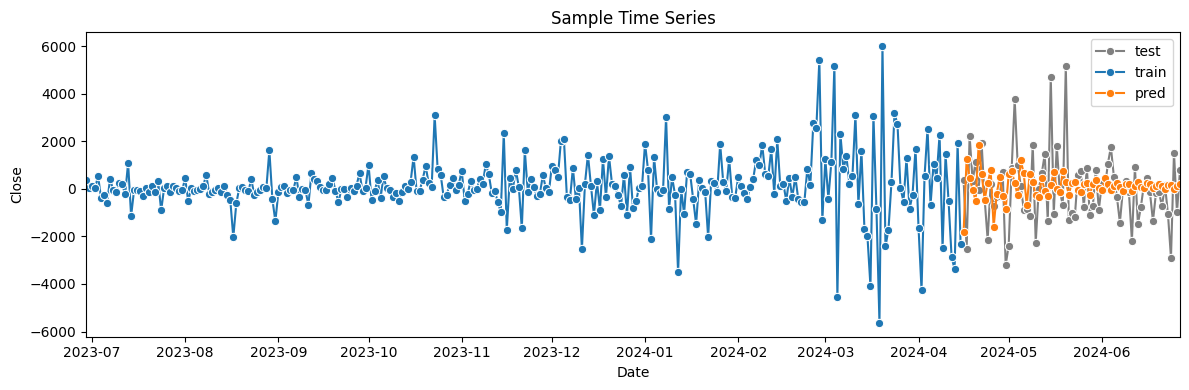

In [48]:
# Assuming 'df_diff' is your DataFrame with 'Date' as the index and 'Close' as the column
df_diff['Date'] = pd.to_datetime(df_diff.index)
df_diff = df_diff.sort_index()

num_samples = len(df_diff)
train_len = int(0.8 * num_samples)

# Split the data into train and test sets
train = df_diff['Close'][:train_len]
test = df_diff['Close'][train_len:]

# Fit the AutoReg model with a lag of 20
ar_model = AutoReg(train, lags=20).fit()

# Print the summary of the model
print(ar_model.summary())

# Predict values
pred = ar_model.predict(start=train_len, end=num_samples-1, dynamic=False)

# Plotting
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.lineplot(x=df_diff['Date'][train_len:], y=test, marker='o', label='test', color='grey')
sns.lineplot(x=df_diff['Date'][:train_len], y=train, marker='o', label='train')
sns.lineplot(x=df_diff['Date'][train_len:], y=pred, marker='o', label='pred')
ax.set_xlim([df_diff['Date'].iloc[0], df_diff['Date'].iloc[-1]])
ax.set_title('Sample Time Series')
plt.tight_layout()
plt.show()


In [ ]:
#MA Model Beibyy